# Zindi CGIAR Root Volume Challenge

As depicted in the picture below, a single cassava plant can have more than one root. The term root volume therefore refers to the total volume of the identified roots of a given plant. In this image, there are at least six roots (labeled from 1 to 6) on the plant.

![](https://zindi-public-release.s3.eu-west-2.amazonaws.com/uploads/image_attachment/image/2559/358c9a4b-527c-4fff-8ff1-725e89510cfd.jpg)

Each folder contains images for the roots of cassava plants generated for the left and right scans at different depths or layers. A Ground Penetrating Radar is used to non-invasively scan the roots of the cassava plants from each side. The raw data collected by the radar is then processed into images. Seven plants are scanned from both sides (left & right) at any given time. This implies that the maximum number of plants in any given image is 7. However this does not mean that all the 7 plants will always be visible in the image of the corresponding scan. The naming convention for images follows this format: XXXXXXXX_S_NNN.png. The characters in the pattern XXXXXXXX consist of random characters. This information is not relevant to you for this project. The S is the side of the scan. It can be L (left) or R (right) depending on the side from which the scan is performed. The three last characters in the image name are digits. These digits correspond to the depth or layer of the scan. Examples of images found in a folder are XXXXXX_L_001.png, XXXXXXXX_R_001.png, XXXXXXX_L_102.png, and XXXXXXXX_R_102.png. In this instance, there are 204 images in the folder; 102 images for each side with layers ranging from 1 up to 102. No assumption should be made about each folder having the same number of images since a different range of layers may be used.

**More about the Competition [here](https://zindi.africa/competitions/cgiar-root-volume-estimation-challenge)**

### PS If you find this notebook helpful, please consider giving it an upvote. Otherwise let's dive into the more interesting part

# 🌱 Understanding the Competition 🚀  

This competition presents a **unique challenge**, and I truly appreciate the effort the organizers have put into designing it! 🎯 Before jumping into coding, let’s take a step back and **understand the task**.  

## 🔍 What is Ground Penetrating Radar (GPR)?  

The dataset in this competition was collected using **Ground Penetrating Radar (GPR)**. Never heard of GPR before? 🤔 Don't worry, I was also confused at first! So, I checked out a few YouTube videos, and this one does a great job explaining how it works:  

[![🎥 Video Thumbnail](https://img.youtube.com/vi/VIDEO_ID/0.jpg)](https://www.youtube.com/watch?v=MfpUA05s0GU)  

After watching the video, the **images in the dataset start to make a lot more sense**! 🎉  

---

## 🏆 Understanding the Task  

Each folder in the dataset contains **GPR-scanned images** of cassava plant roots, captured from the **left and right** sides at different depths. 🌿 The scans are processed from raw radar data, allowing us to **analyze root structures without digging up the plants**. 🛠️  

At most, an image may contain **up to 7 plants**, though not all may be visible in every scan. 👀  

### 🎯 Our mission:  

1️⃣ **Segment the root data** – Identify and extract root structures from the GPR images.  
2️⃣ **Estimate the root volume** – Use the segmented roots to predict the **total root volume** of each cassava plant.  

Since this is a **starter notebook**, we will begin by using the **pre-trained segmentation models** provided by the organizers. These models are:  

✅ `best_early.pt` – Trained on **early-stage** cassava root data.  
✅ `best_late.pt` – Trained on **late-stage** cassava root data.  
✅ `best_full.pt` – Trained on data from **both growth stages**.  

You can **use these models**, **fine-tune them**, or **develop your own** from scratch! 💡 The choice is yours!  

---

## 📂 Dataset Insights  

🔹 The images follow the naming pattern: **`XXXXXXXX_S_NNN.png`**, where:  
   - `XXXXXXXX` ➝ Random identifier (not relevant to the task).  
   - `S` ➝ Scan **side** (`L` = Left, `R` = Right).  
   - `NNN` ➝ **Depth** layer (e.g., `001`, `052`, `102`).  

🔹 **Left and right images** do not always have the same dimensions. 📏  
🔹 **Root visibility varies** at different depths, so choosing the right images is **critical**!  
🔹 A **CSV file** provides suggested image ranges, but you're free to experiment.

---

## 🚀 Next Steps  

Now that we understand the task, let’s **load the data** and run the provided models to get our **first results**! 🎉  

🔹 **Step 1:** Load the dataset   
🔹 **Step 2:** Run the segmentation models <br>
🔹 **Step 3:** Generate a new dataset <br>
🔹 **Step 4:** Train a new Model on this generated dataset <br>
🔹 **Step 5:** Run Inference, submit

Let’s dive in! 🔥🚀  


# Import the Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
from pathlib import Path
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import os
from typing import List
import re
from tqdm import tqdm
import lightning as L
from torch.utils.data import DataLoader, Dataset
import torch
from torchvision.transforms import v2
from torch import nn

# Load the data

In [2]:
TRAIN_DATA_PATH = 'data/train'
TEST_DATA_PATH = 'data/test'

In [3]:
train_df = pd.read_csv('Train.csv')
test_df = pd.read_csv("Test.csv")
submission_df = pd.read_csv("Sample_Submission.csv")

In [4]:
df = train_df[['Stage']].value_counts()
df

Stage
Early    370
Late      16
Name: count, dtype: int64

In [5]:
train_df.head()

,ID,FolderName,PlantNumber,Side,Start,End,RootVolume,Genotype,Stage
0,ID_826322_Lbmaya,A6dzrkjqvl,3,L,33,42,0.9,IITA-TMS-IBA000070,Early
1,ID_718181_Bslpwx,Ypktwvqjbn,7,L,33,41,1.5,IBA154810,Early
2,ID_465762_L1n61d,Ox18ob0syv,4,R,21,28,2.7,IBA980581,Early
3,ID_626872_Pbmx2e,Hqcekwpxgu,2,R,30,39,2.6,IITA-TMS-IBA000070,Early
4,ID_518846_Opko8c,Ummqfuetoc,1,R,17,26,2.7,IBA980581,Early


In [6]:
test_df.head()

,ID,FolderName,PlantNumber,Side,Start,End,Genotype,Stage
0,ID_208667_Hnkl8q,L5l1h3kekg,7,L,38,50,IITA-TMS-IBA000070,Early
1,ID_285249_Jnjvav,Wgutyon8uu,6,R,23,37,TMEB419,Early
2,ID_697947_Yec6bd,Mylwjeq6tq,3,R,19,42,IBA980581,Early
3,ID_534638_X3j91f,Pfp24vx905,2,R,27,34,TMEB419,Early
4,ID_929298_Xvymuz,Mrw7chmalv,4,R,30,43,IBA154810,Early


In [8]:
test_df.shape, train_df.shape, submission_df.shape

((130, 8), (386, 9), (130, 2))

In [9]:
submission_df.head()

,ID,RootVolume
0,ID_208667_Hnkl8q,0
1,ID_285249_Jnjvav,0
2,ID_697947_Yec6bd,0
3,ID_534638_X3j91f,0
4,ID_929298_Xvymuz,0


In [10]:
test_df['Stage'].value_counts()

Stage
Early    125
Late       5
Name: count, dtype: int64

In [11]:
test_df['Genotype'].value_counts()

Genotype
TMEB693               34
TMEB419               29
IITA-TMS-IBA000070    22
IBA980581             21
IBA154810             19
IKN130010              3
DIXON                  2
Name: count, dtype: int64

In [12]:
train_df['FolderName'].unique().size, test_df['FolderName'].unique().size

(98, 62)

In [16]:
folder = "Ypktwvqjbn"
df = train_df[train_df['FolderName'] == folder]

df[['FolderName', 'PlantNumber', 'Side', 'Start', 'End', 'RootVolume']]
df

,ID,FolderName,PlantNumber,Side,Start,End,RootVolume,Genotype,Stage
1,ID_718181_Bslpwx,Ypktwvqjbn,7,L,33,41,1.5,IBA154810,Early
177,ID_737941_Ojh6bl,Ypktwvqjbn,4,L,33,41,0.9,IBA154810,Early
240,ID_717965_Ps4xjq,Ypktwvqjbn,3,L,33,41,1.5,IBA154810,Early
343,ID_444311_Tvefbg,Ypktwvqjbn,5,L,33,41,1.7,IBA154810,Early


In [17]:
len(os.listdir("data/test/A6dzrkjqvl"))

164

# Load the segmentation models

In [18]:
# Since the organizers didn't provide performance metrics, we will be using all the models (For Now)
segmentation_models = {
    "full" : YOLO("Models/Models/best_full.pt"),
    "early" : YOLO("Models/Models/best_early.pt"),
    "late" : YOLO("Models/Models/best_late.pt")
}

In [31]:
sample = "data/train/A2miww5mfx/A2miww5mfx_L_014.png"

seg_model = segmentation_models['full']
results = seg_model(sample)


image 1/1 c:\Users\Reinhard\Documents\computer_vision_projects\root_volume_estimation_challenge\data\train\A2miww5mfx\A2miww5mfx_L_014.png: 32x640 4 roots, 463.7ms
Speed: 0.7ms preprocess, 463.7ms inference, 2.5ms postprocess per image at shape (1, 3, 32, 640)


In [27]:
sample_image = Image.open(sample)
sample_image

In [21]:
sample_image.mode

'RGBA'

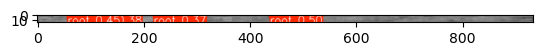

In [32]:
img = results[0].plot()
plt.imshow(img)

In [34]:
for result in results:
    for box in result.boxes.xywh:
        x, y, w, h = box  # x, y are center coordinates
        print(f"Bounding Box - X: {x}, Y: {y}, Width: {w}, Height: {h}")

Bounding Box - X: 451.03765869140625, Y: 3.013875961303711, Width: 25.670867919921875, Height: 6.027751922607422
Bounding Box - X: 104.74575805664062, Y: 4.812622547149658, Width: 93.61978912353516, Height: 9.625245094299316
Bounding Box - X: 124.95436096191406, Y: 4.5839385986328125, Width: 52.850868225097656, Height: 9.167877197265625
Bounding Box - X: 229.66575622558594, Y: 2.718564987182617, Width: 20.830291748046875, Height: 5.437129974365234


In [35]:
segmentation_models.keys()

dict_keys(['full', 'early', 'late'])

In [36]:
# Since the organizers didn't provide performance metrics, we will be using all the models (For Now)
segmentation_model = {
    "full" : YOLO("Models/Models/best_full.pt"),
}

In [37]:

def get_segmented_images(image_paths, display_image=False):
    """Extracts and merges segments from images, returning only images with detections."""

    for model in segmentation_model.keys():
        model = segmentation_model[model]
        results = model(image_paths, verbose=False)

        if len(results[0].boxes.xyxy) != 0:
            break

    if len(results[0].boxes.xyxy) == 0:
        # Incase of no detections, return all the images (Still thinking of better ways to overcome this)
        return [Image.open(img) for img in image_paths]
        
    segmented_images = []
    
    for img_path, result in zip(image_paths, results):
        original_image = Image.open(img_path)
        merged_image = Image.new("RGBA", original_image.size, (0, 0, 0, 0))
        
        # Skip if no detections
        if len(result.boxes.xyxy) == 0:
            continue 
            
        # Extract and paste segments
        for box in result.boxes.xyxy:
            x1, y1, x2, y2 = map(int, box.tolist())
            segment = original_image.crop((x1, y1, x2, y2))
            merged_image.paste(segment, (x1, y1))
            
        segmented_images.append(merged_image)

    # Display Images
    if display_image and segmented_images:
        fig, axes = plt.subplots(1, len(segmented_images), figsize=(15, 10))
        if len(segmented_images) == 1:
            axes = [axes]
        for ax, img in zip(axes, segmented_images):
            ax.imshow(img)
            ax.axis("off")
        plt.show()

    return segmented_images

**Explanation** <br>
We are going to use `get_segmented_images` function to process a set of images and extracts the regions of interest (i.e., root segments) using a pre-trained segmentation models. It then returns the segmented images where roots are detected, or all images if no detections are made.

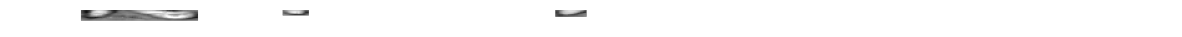

[<PIL.Image.Image image mode=RGBA size=934x14>]

In [38]:
get_segmented_images([sample], display_image = True)

In [39]:
# The function retrieves images from a specified folder
# based on the scan side (left or right) and a layer range
# (from a starting layer to an ending layer).

def get_images_within_range(base_path: Path, folder: str, side: str, start: int, end: int) -> list[Path]:
    """
    Get images from a folder that match the specified side (L/R) and layer range.
    
    Args:
        base_path: Root directory containing all folders
        folder: Name of the target folder (e.g., 'Ypktwvqjbn')
        side: Scan side to filter ('L' or 'R')
        start: Starting layer (inclusive)
        end: Ending layer (inclusive)
    """
    folder_path = base_path / folder
    
    # Get all files in the folder
    try:
        images = os.listdir(folder_path)
    except FileNotFoundError:
        return []

    # Regex pattern to extract side and layer from filenames
    pattern = re.compile(r'_([LR])_(\d{3})\.png$')
    
    selected_images = []
    
    for img_name in images:
        match = pattern.search(img_name)
        if match:
            # Extract side and layer from filename
            img_side = match.group(1)
            layer = int(match.group(2))
            
            # Check if matches criteria
            if img_side == side and start <= layer <= end:
                selected_images.append(folder_path / img_name)
    
    return selected_images

In [40]:
from pathlib import Path

# test and see
sample_images = get_images_within_range(Path(TRAIN_DATA_PATH), "Ypktwvqjbn", "L", 33, 41)
sample_images

[WindowsPath('data/train/Ypktwvqjbn/Ypktwvqjbn_L_033.png'),
 WindowsPath('data/train/Ypktwvqjbn/Ypktwvqjbn_L_034.png'),
 WindowsPath('data/train/Ypktwvqjbn/Ypktwvqjbn_L_035.png'),
 WindowsPath('data/train/Ypktwvqjbn/Ypktwvqjbn_L_036.png'),
 WindowsPath('data/train/Ypktwvqjbn/Ypktwvqjbn_L_037.png'),
 WindowsPath('data/train/Ypktwvqjbn/Ypktwvqjbn_L_038.png'),
 WindowsPath('data/train/Ypktwvqjbn/Ypktwvqjbn_L_039.png'),
 WindowsPath('data/train/Ypktwvqjbn/Ypktwvqjbn_L_040.png'),
 WindowsPath('data/train/Ypktwvqjbn/Ypktwvqjbn_L_041.png')]

In [41]:
get_segmented_images(sample_images, display_image = True)

[<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>]

In [42]:
# finally merge all of the image segments into one
def merge_segmented_images(path: Path, folder: str, side: str, start: int, end: int):
    images_in_range = get_images_within_range(path, folder, side, start, end)
    segmented_images = get_segmented_images(images_in_range)

    # Determine final dimensions for the merged image
    total_width = sum(img.width for img in segmented_images)  # Sum of all widths
    max_height = max(img.height for img in segmented_images)  # Max height among all images

    # Create a blank canvas with a transparent background
    merged_image = Image.new("RGBA", (total_width, max_height), (0, 0, 0, 0))

    # Paste each segmented image next to the previous one (left to right)
    x_offset = 0
    for img in segmented_images:
        merged_image.paste(img, (x_offset, 0), img)  # Paste at correct position
        x_offset += img.width  # Move x-offset to the right for the next image

    return merged_image

In [43]:
merged_image = merge_segmented_images(Path(TRAIN_DATA_PATH), "Ox18ob0syv", "R", 21, 28)
merged_image

In [44]:
OUTPUT_IMAGE_DIR = Path("C:/Users/Reinhard/Documents/computer_vision_projects/root_volume_estimation_challenge/merged_images/")
os.makedirs(OUTPUT_IMAGE_DIR, exist_ok = True)

TRAIN_OUTPUT_DIR = OUTPUT_IMAGE_DIR / "Train"
TEST_OUTPUT_DIR = OUTPUT_IMAGE_DIR / "Test"

os.makedirs(TRAIN_OUTPUT_DIR, exist_ok = True)
os.makedirs(TEST_OUTPUT_DIR, exist_ok = True)

In [31]:
train_df.head()

,ID,FolderName,PlantNumber,Side,Start,End,RootVolume,Genotype,Stage
0,ID_826322_Lbmaya,A6dzrkjqvl,3,L,33,42,0.9,IITA-TMS-IBA000070,Early
1,ID_718181_Bslpwx,Ypktwvqjbn,7,L,33,41,1.5,IBA154810,Early
2,ID_465762_L1n61d,Ox18ob0syv,4,R,21,28,2.7,IBA980581,Early
3,ID_626872_Pbmx2e,Hqcekwpxgu,2,R,30,39,2.6,IITA-TMS-IBA000070,Early
4,ID_518846_Opko8c,Ummqfuetoc,1,R,17,26,2.7,IBA980581,Early


# Generate the new dataset

In [45]:
# Iterate through all the  images in the df
def generate_merged_images(df, output_path, input_path):
    gen_image_paths = []
    
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Merging Images"):
        gen_image = merge_segmented_images(
            path=Path(input_path),
            folder=row["FolderName"],
            side=row["Side"],
            start=row["Start"],
            end=row["End"]
        )
        img_path = Path(output_path / f"{row['ID']}.png")
        gen_image.save(img_path)
        gen_image_paths.append(img_path)

    df['image segments'] = gen_image_paths
    return df

In [46]:
new_train_df = generate_merged_images(train_df, TRAIN_OUTPUT_DIR, TRAIN_DATA_PATH)

Merging Images: 100%|██████████| 386/386 [17:48<00:00,  2.77s/it]


In [30]:
!tree root_volume_estimation_challenge --filelimit=10

Too many parameters - --filelimit=10


In [47]:
new_train_df.head()

,ID,FolderName,PlantNumber,Side,Start,End,RootVolume,Genotype,Stage,image segments
0,ID_826322_Lbmaya,A6dzrkjqvl,3,L,33,42,0.9,IITA-TMS-IBA000070,Early,C:\Users\Reinhard\Documents\computer_vision_pr...
1,ID_718181_Bslpwx,Ypktwvqjbn,7,L,33,41,1.5,IBA154810,Early,C:\Users\Reinhard\Documents\computer_vision_pr...
2,ID_465762_L1n61d,Ox18ob0syv,4,R,21,28,2.7,IBA980581,Early,C:\Users\Reinhard\Documents\computer_vision_pr...
3,ID_626872_Pbmx2e,Hqcekwpxgu,2,R,30,39,2.6,IITA-TMS-IBA000070,Early,C:\Users\Reinhard\Documents\computer_vision_pr...
4,ID_518846_Opko8c,Ummqfuetoc,1,R,17,26,2.7,IBA980581,Early,C:\Users\Reinhard\Documents\computer_vision_pr...


In [ ]:
new_test_df = generate_merged_images(test_df, TEST_OUTPUT_DIR, TEST_DATA_PATH)

Merging Images:   0%|          | 0/130 [00:00<?, ?it/s]

Merging Images:  70%|███████   | 91/130 [03:19<01:10,  1.80s/it]

In [36]:
def display_generated_images(image_paths):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()

    for i, img_path in enumerate(image_paths[:4]):  # Display first 4 images
        image = Image.open(img_path)
        axes[i].imshow(image)
        axes[i].axis("off")  # Hide axes
        axes[i].set_title(f"Image {i+1}")

    plt.tight_layout()
    plt.show()

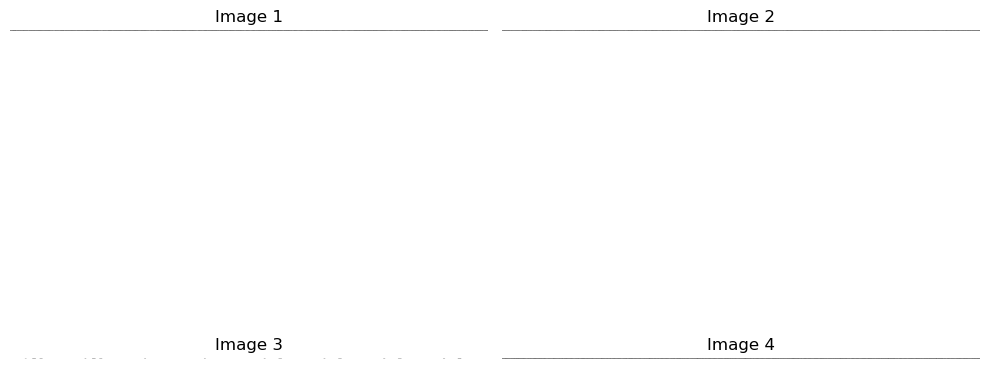

In [37]:
# Display Train

display_generated_images(new_train_df['image segments'].values)

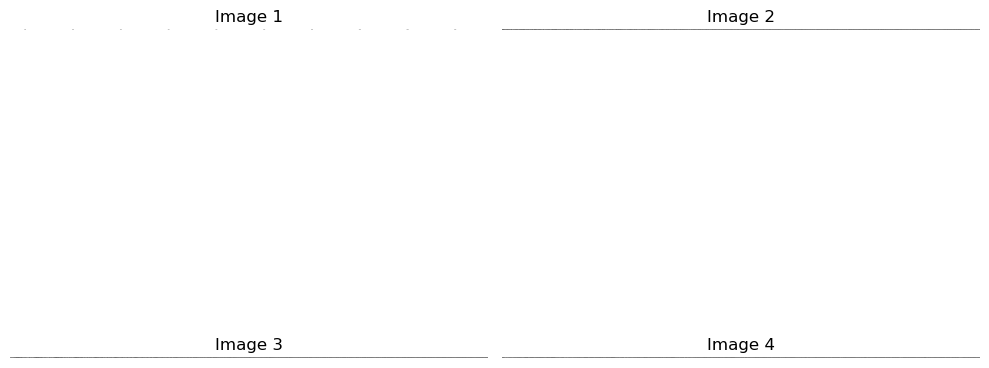

In [38]:
display_generated_images(new_test_df['image segments'].values)

In [40]:
new_test_df.head()

,ID,FolderName,PlantNumber,Side,Start,End,Genotype,Stage,image segments
0,ID_208667_Hnkl8q,L5l1h3kekg,7,L,38,50,IITA-TMS-IBA000070,Early,C:\Users\Reinhard\Documents\computer_vision_pr...
1,ID_285249_Jnjvav,Wgutyon8uu,6,R,23,37,TMEB419,Early,C:\Users\Reinhard\Documents\computer_vision_pr...
2,ID_697947_Yec6bd,Mylwjeq6tq,3,R,19,42,IBA980581,Early,C:\Users\Reinhard\Documents\computer_vision_pr...
3,ID_534638_X3j91f,Pfp24vx905,2,R,27,34,TMEB419,Early,C:\Users\Reinhard\Documents\computer_vision_pr...
4,ID_929298_Xvymuz,Mrw7chmalv,4,R,30,43,IBA154810,Early,C:\Users\Reinhard\Documents\computer_vision_pr...


# Model Traning

In [41]:
train_transform = v2.Compose([
    v2.Resize(size=(20, 150), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),  
    v2.Normalize(mean=[0.5], std=[0.5])
])

# Testing Transform
test_transform = v2.Compose([
    v2.Resize(size=(20, 150), antialias=True),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),  
    v2.Normalize(mean=[0.5], std=[0.5])
])

img = train_transform(sample_image)
img.shape

torch.Size([4, 20, 150])

In [42]:
img.size

<function Image.size>

In [43]:
sample_image = Image.open(new_train_df['image segments'].iloc[6])
train_transform(sample_image)

Image([[[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]],

       [[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]],

       [[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]],

       [[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., 

In [44]:
# define the dataset
class RootVolumeDataset(Dataset):
    def __init__(self, df : pd.DataFrame, transform = None, is_train = True):
        super().__init__()
        self.df = df
        self.transform = transform
        self.is_train = is_train

    def __getitem__(self, index):
        image = Image.open(self.df['image segments'].iloc[index]).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.is_train:
            label = self.df['RootVolume'].iloc[index]

            return image, torch.tensor(label, dtype=torch.float32)

        return image

    def __len__(self):
        return len(self.df)

In [45]:
def seed_everything(seed):
    torch.manual_seed(seed) 
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False
    L.pytorch.seed_everything(seed, workers=True)
    
seed_everything(42)

Seed set to 42


In [46]:
train_dataset = RootVolumeDataset(new_train_df, train_transform)
test_dataset = RootVolumeDataset(new_test_df, test_transform, is_train = False)

In [47]:
train_dataset[0][0].shape, train_dataset[0][0].shape

(torch.Size([3, 20, 150]), torch.Size([3, 20, 150]))

In [48]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [49]:
# simple CNN for the predictions
class RootVolumeRegressor(L.LightningModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.lr = lr

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        # Fully Connected Regression Head
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Regression output
        )

        self.criterion = nn.MSELoss()

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        images, targets = batch
        preds = self(images).squeeze()
        loss = self.criterion(preds, targets)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        preds = self(images).squeeze()
        loss = self.criterion(preds, targets)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

model = RootVolumeRegressor()
model

RootVolumeRegressor(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)

# Training using torch lightning 

In [123]:
def seed_everything(seed):
    torch.manual_seed(seed) 
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False
    L.pytorch.seed_everything(seed, workers=True)
    
seed_everything(42)

Seed set to 42


In [50]:
# 
trainer = L.Trainer(max_epochs = 50)

trainer.fit(model, train_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Reinhard\anaconda3\envs\deeplearning\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
c:\Users\Reinhard\anaconda3\envs\deeplearning\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | conv_layers | Sequential | 23.6 K | 

Epoch 49: 100%|██████████| 25/25 [00:05<00:00,  4.44it/s, v_num=21, train_loss=2.020] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 25/25 [00:05<00:00,  4.42it/s, v_num=21, train_loss=2.020]


In [51]:
def get_model_preds(model, dataloader, device="cuda" if torch.cuda.is_available() else "cpu"):
    preds, targets = [], []
    model.to(device)
    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Predict
            preds.extend(outputs.cpu().numpy().flatten())
            targets.extend(labels.cpu().numpy().flatten())

    return np.array(preds), np.array(targets)

train_preds, target = get_model_preds(model, train_dataloader)

In [52]:
def calculate_rmse(preds, targets):
    """
    Compute Root Mean Squared Error (RMSE) between predictions and ground truth targets.
    """
    preds = np.array(preds) if not isinstance(preds, np.ndarray) else preds
    targets = np.array(targets) if not isinstance(targets, np.ndarray) else targets
    
    return np.sqrt(np.mean((preds - targets) ** 2))

calculate_rmse(train_preds, target)

1.4858037

In [53]:
def get_test_preds(model, dataloader, device="cuda" if torch.cuda.is_available() else "cpu"):
    preds = []
    model.to(device)
    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            images = batch if isinstance(batch, torch.Tensor) else batch[0]
            images = images.to(device)

            outputs = model(images)
            preds.extend(outputs.cpu().numpy().flatten()) 

    return np.array(preds)

test_preds = get_test_preds(model, test_dataloader)

In [54]:
test_df['RootVolume'] = test_preds
test_df.head()

,ID,FolderName,PlantNumber,Side,Start,End,Genotype,Stage,image segments,RootVolume
0,ID_208667_Hnkl8q,L5l1h3kekg,7,L,38,50,IITA-TMS-IBA000070,Early,C:\Users\Reinhard\Documents\computer_vision_pr...,2.196713
1,ID_285249_Jnjvav,Wgutyon8uu,6,R,23,37,TMEB419,Early,C:\Users\Reinhard\Documents\computer_vision_pr...,1.945417
2,ID_697947_Yec6bd,Mylwjeq6tq,3,R,19,42,IBA980581,Early,C:\Users\Reinhard\Documents\computer_vision_pr...,1.897175
3,ID_534638_X3j91f,Pfp24vx905,2,R,27,34,TMEB419,Early,C:\Users\Reinhard\Documents\computer_vision_pr...,1.951070
4,ID_929298_Xvymuz,Mrw7chmalv,4,R,30,43,IBA154810,Early,C:\Users\Reinhard\Documents\computer_vision_pr...,1.907450


In [ ]:
submission = test_df[['ID', 'RootVolume']]
submission.to_csv("submission_15.csv", index = False)
submission.head()

,ID,RootVolume
0,ID_208667_Hnkl8q,2.196713
1,ID_285249_Jnjvav,1.945417
2,ID_697947_Yec6bd,1.897175
3,ID_534638_X3j91f,1.951070
4,ID_929298_Xvymuz,1.907450


: 

### Assesing the performance of the segmentation models

In [84]:
import os 
import random
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

In [101]:
test_images_dir = "data/test/"
model_paths = {
    "early": "Models/Models/best_early.pt",
    "late": "Models/Models/best_late.pt",
    "full": "Models/Models/best_full.pt"
}

In [105]:
num_samples = 10
random_folders = random.sample(os.listdir(test_images_dir), num_samples)
test_images = []
for folder in random_folders:
    folder_path = os.path.join(test_images_dir, folder)
    images = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
    if images:
        test_images.append(random.choice(images))


# Load the models 
models = {name: YOLO(path) for name, path in model_paths.items()}

In [123]:
# Run inference and visualize results
def visualize_results(image_path, models):
    original_img = cv2.imread(image_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    fig, axes = plt.subplots(1, len(models) + 1, figsize=(15, 5))
    
    # Show original image
    axes[0].imshow(original_img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    # Process each model
    for i, (model_name, model) in enumerate(models.items()):
        results = model(image_path, conf= 0.2)[0]  # Get prediction
        
        # Create a blank mask
        mask = np.zeros_like(original_img[:, :, 0], dtype=np.uint8)
        
        # Draw segmentation masks
        if results.masks is not None:
            for seg in results.masks.xy:
                seg = np.array(seg, np.int32).reshape((-1, 1, 2))
                cv2.fillPoly(mask, [seg], 255)

        # Overlay mask on image
        overlay = original_img.copy()
        overlay[mask > 0] = (255, 0, 0)  # Highlight mask in red

        axes[i+1].imshow(overlay)
        axes[i+1].set_title(f"{model_name} Model")
        axes[i+1].axis("off")
    
    plt.show()



image 1/1 c:\Users\Reinhard\Documents\computer_vision_projects\root_volume_estimation_challenge\data\test\Vlcavd4dwj\Vlcavd4dwj_R_061.png: 32x640 (no detections), 2242.1ms
Speed: 43.2ms preprocess, 2242.1ms inference, 34.0ms postprocess per image at shape (1, 3, 32, 640)

image 1/1 c:\Users\Reinhard\Documents\computer_vision_projects\root_volume_estimation_challenge\data\test\Vlcavd4dwj\Vlcavd4dwj_R_061.png: 32x640 (no detections), 1986.4ms
Speed: 2.6ms preprocess, 1986.4ms inference, 14.1ms postprocess per image at shape (1, 3, 32, 640)

image 1/1 c:\Users\Reinhard\Documents\computer_vision_projects\root_volume_estimation_challenge\data\test\Vlcavd4dwj\Vlcavd4dwj_R_061.png: 32x640 (no detections), 2626.6ms
Speed: 11.9ms preprocess, 2626.6ms inference, 35.8ms postprocess per image at shape (1, 3, 32, 640)


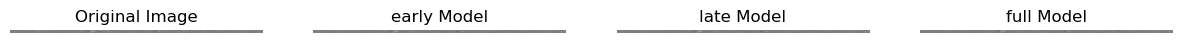


image 1/1 c:\Users\Reinhard\Documents\computer_vision_projects\root_volume_estimation_challenge\data\test\Vlcavd4dwj\Vlcavd4dwj_L_057.png: 32x640 (no detections), 913.0ms
Speed: 20.3ms preprocess, 913.0ms inference, 0.6ms postprocess per image at shape (1, 3, 32, 640)

image 1/1 c:\Users\Reinhard\Documents\computer_vision_projects\root_volume_estimation_challenge\data\test\Vlcavd4dwj\Vlcavd4dwj_L_057.png: 32x640 (no detections), 1161.3ms
Speed: 0.8ms preprocess, 1161.3ms inference, 0.7ms postprocess per image at shape (1, 3, 32, 640)

image 1/1 c:\Users\Reinhard\Documents\computer_vision_projects\root_volume_estimation_challenge\data\test\Vlcavd4dwj\Vlcavd4dwj_L_057.png: 32x640 (no detections), 726.1ms
Speed: 0.9ms preprocess, 726.1ms inference, 0.5ms postprocess per image at shape (1, 3, 32, 640)


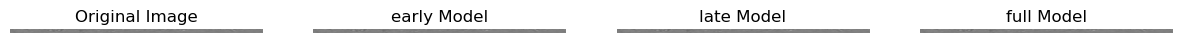


image 1/1 c:\Users\Reinhard\Documents\computer_vision_projects\root_volume_estimation_challenge\data\test\Vlcavd4dwj\Vlcavd4dwj_R_002.png: 32x640 2 roots, 904.2ms
Speed: 0.7ms preprocess, 904.2ms inference, 99.2ms postprocess per image at shape (1, 3, 32, 640)

image 1/1 c:\Users\Reinhard\Documents\computer_vision_projects\root_volume_estimation_challenge\data\test\Vlcavd4dwj\Vlcavd4dwj_R_002.png: 32x640 8 roots, 428.2ms
Speed: 10.6ms preprocess, 428.2ms inference, 5.2ms postprocess per image at shape (1, 3, 32, 640)

image 1/1 c:\Users\Reinhard\Documents\computer_vision_projects\root_volume_estimation_challenge\data\test\Vlcavd4dwj\Vlcavd4dwj_R_002.png: 32x640 6 roots, 795.1ms
Speed: 0.8ms preprocess, 795.1ms inference, 4.0ms postprocess per image at shape (1, 3, 32, 640)


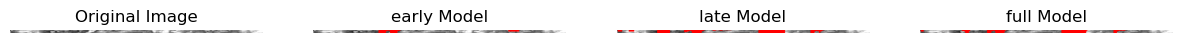


image 1/1 c:\Users\Reinhard\Documents\computer_vision_projects\root_volume_estimation_challenge\data\test\Vlcavd4dwj\Vlcavd4dwj_L_015.png: 32x640 (no detections), 330.9ms
Speed: 1.6ms preprocess, 330.9ms inference, 0.5ms postprocess per image at shape (1, 3, 32, 640)

image 1/1 c:\Users\Reinhard\Documents\computer_vision_projects\root_volume_estimation_challenge\data\test\Vlcavd4dwj\Vlcavd4dwj_L_015.png: 32x640 1 root, 365.5ms
Speed: 0.6ms preprocess, 365.5ms inference, 2.5ms postprocess per image at shape (1, 3, 32, 640)

image 1/1 c:\Users\Reinhard\Documents\computer_vision_projects\root_volume_estimation_challenge\data\test\Vlcavd4dwj\Vlcavd4dwj_L_015.png: 32x640 (no detections), 336.3ms
Speed: 0.8ms preprocess, 336.3ms inference, 0.5ms postprocess per image at shape (1, 3, 32, 640)


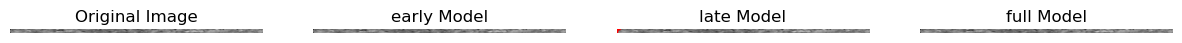


image 1/1 c:\Users\Reinhard\Documents\computer_vision_projects\root_volume_estimation_challenge\data\test\Vlcavd4dwj\Vlcavd4dwj_L_059.png: 32x640 (no detections), 380.2ms
Speed: 0.5ms preprocess, 380.2ms inference, 0.4ms postprocess per image at shape (1, 3, 32, 640)

image 1/1 c:\Users\Reinhard\Documents\computer_vision_projects\root_volume_estimation_challenge\data\test\Vlcavd4dwj\Vlcavd4dwj_L_059.png: 32x640 (no detections), 346.2ms
Speed: 0.6ms preprocess, 346.2ms inference, 0.8ms postprocess per image at shape (1, 3, 32, 640)

image 1/1 c:\Users\Reinhard\Documents\computer_vision_projects\root_volume_estimation_challenge\data\test\Vlcavd4dwj\Vlcavd4dwj_L_059.png: 32x640 (no detections), 346.4ms
Speed: 0.7ms preprocess, 346.4ms inference, 0.5ms postprocess per image at shape (1, 3, 32, 640)


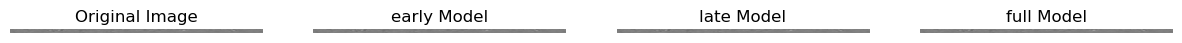

In [139]:
for img_path in test_images:
    visualize_results(img_path, models)

## Volume stimation

In [96]:
import os
import random
import cv2
import torch
import numpy 
import pandas
import matplotlib.pyplot as plt
from ultralytics import YOLO
from sklearn.metrics import mean_squared_error

In [108]:
test_images_dir = "data/test/"
train_csv = "Train.csv"
model_paths = {
    "early": "Models/Models/best_early.pt",
    "late": "Models/Models/best_late.pt",
    "full": "Models/Models/best_full.pt"
}


In [98]:
train_data = pd.read_csv(train_csv)

In [110]:
num_samples = 5
random_folders = random.sample(os.listdir(test_images_dir), num_samples)
test_images = []
for foler in random_folders:
    folder_path = os.path.join(test_images_dir, folder)
    images = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
    if images:
        test_images.append(random.choice(images))

In [112]:
models = {name: YOLO(path) for name, path in model_paths.items()}

In [113]:
train_data.head()

,ID,FolderName,PlantNumber,Side,Start,End,RootVolume,Genotype,Stage
0,ID_826322_Lbmaya,A6dzrkjqvl,3,L,33,42,0.9,IITA-TMS-IBA000070,Early
1,ID_718181_Bslpwx,Ypktwvqjbn,7,L,33,41,1.5,IBA154810,Early
2,ID_465762_L1n61d,Ox18ob0syv,4,R,21,28,2.7,IBA980581,Early
3,ID_626872_Pbmx2e,Hqcekwpxgu,2,R,30,39,2.6,IITA-TMS-IBA000070,Early
4,ID_518846_Opko8c,Ummqfuetoc,1,R,17,26,2.7,IBA980581,Early


In [ ]:
def estimate_volume(image_path, model):
    original_img = cv2.imread(image_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    results = model(image_path, conf=0.2)[0]

    mask = np.zeros_like(original_img[:, :, 0], dtype=np.uint8)

    if results.masks is not None:
        for seg in results.masks.xy:
            seg = np.array(seg, np.int32).reshape((-1, 1, 2))
            cv2.fillPoly(mask, [seg], 255)
    
    root_area = np.sum(mask > 0)

    depth_layer = 0.5
    volume = root_area * depth_layer   

    return volume

In [119]:
predictions = {"image": [], "early": [], "late": [], "full": []}

In [120]:
for img_path in test_images:
    img_name = os.path.basename(img_path)
    predictions["image"].append(img_name)
    
    for model_name, model in models.items():
        volume = estimate_volume(img_path, model)
        predictions[model_name].append(volume)



image 1/1 c:\Users\Reinhard\Documents\computer_vision_projects\root_volume_estimation_challenge\data\test\Vlcavd4dwj\Vlcavd4dwj_R_061.png: 32x640 (no detections), 736.2ms
Speed: 39.2ms preprocess, 736.2ms inference, 21.6ms postprocess per image at shape (1, 3, 32, 640)

image 1/1 c:\Users\Reinhard\Documents\computer_vision_projects\root_volume_estimation_challenge\data\test\Vlcavd4dwj\Vlcavd4dwj_R_061.png: 32x640 (no detections), 696.0ms
Speed: 34.1ms preprocess, 696.0ms inference, 18.4ms postprocess per image at shape (1, 3, 32, 640)

image 1/1 c:\Users\Reinhard\Documents\computer_vision_projects\root_volume_estimation_challenge\data\test\Vlcavd4dwj\Vlcavd4dwj_R_061.png: 32x640 (no detections), 1054.7ms
Speed: 47.6ms preprocess, 1054.7ms inference, 30.4ms postprocess per image at shape (1, 3, 32, 640)

image 1/1 c:\Users\Reinhard\Documents\computer_vision_projects\root_volume_estimation_challenge\data\test\Vlcavd4dwj\Vlcavd4dwj_L_057.png: 32x640 (no detections), 1372.8ms
Speed: 4.8ms

In [121]:
pred_df = pd.DataFrame(predictions)


In [122]:
print(pred_df)

                  image  early    late   full
0  Vlcavd4dwj_R_061.png    0.0     0.0    0.0
1  Vlcavd4dwj_L_057.png    0.0     0.0    0.0
2  Vlcavd4dwj_R_002.png  712.5  1981.5  466.0
3  Vlcavd4dwj_L_015.png    0.0     0.0    0.0
4  Vlcavd4dwj_L_059.png    0.0     0.0    0.0


## Improved tweaked model

In [188]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
import os

In [231]:
class CassavaDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform


        #Filter  out no-existing folders
        self.valid_samples = self.data[self.data['FolderName'].apply(lambda x: os.path.exists(os.path.join(self.img_dir, x)))].reset_index(drop=True)   

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        folder_name = self.data.iloc[idx]['FolderName']
        img_path = os.path.join(self.img_dir, folder_name)

        possible_extensions = ['.png', '.jpg', '.jpeg']
        image_file = None
        for ext in possible_extensions:
            temp_path = img_path + ext
            if os.path.exists(temp_path):
                image_file = temp_path
                break

        if image_file is None:
            new_idx = random.randint(0, len(self.valid_samples) - 1)
            return self.__getitem__(new_idx)
        
        image = Image.open(image_file).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.data.iloc[idx]['RootVolume']

        return image, label
                     

In [232]:
# Unfreeze only the last few layers
for param in model.resnet.fc.parameters():
    param.requires_grad = True  # Train only the final layer

In [233]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

train_dataset = CassavaDataset(csv_file='Train.csv',img_dir = 'data/train', transform=transform)
val_dataset = CassavaDataset(csv_file='Test.csv',img_dir = 'data/test', transform=transform)

In [234]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  

In [235]:
import torchvision.models as models
import torch
import torch.nn as nn

class RootVolumeModel(nn.Module):
    def __init__(self, pretrained=True):
        super(RootVolumeModel, self).__init__()
        self.resnet = models.resnet50(pretrained=pretrained)

        # Freeze all layers first
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Unfreeze only the last few layers
        for param in self.resnet.fc.parameters():
            param.requires_grad = True

        # Replce Fully connected layer
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.resnet(x)
    
# Initialize Model
#Initialize Model
model = RootVolumeModel(pretrained=True)

c:\Users\Reinhard\anaconda3\envs\deeplearning\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Reinhard\anaconda3\envs\deeplearning\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [236]:
import torch.optim as optim

#Loss Function
criterion = nn.MSELoss()

# optimizer (only updating unfrozen layers)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

RootVolumeModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

In [237]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        try:
            images, labels = images.to(device), labels.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        except FileNotFoundError as e:
            print(f"Error: {e}")
            continue

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")


RecursionError: maximum recursion depth exceeded